# lib

In [48]:
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

# preprocessing data

In [3]:
!pip install pandas_ta

     |████████████████████████████████| 115 kB 5.1 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=508d44f928aba3910e628aeac3f59d799ab80344c3ae54033446e058d5e00548
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


In [4]:
import pandas_ta as ta

In [5]:
from google.colab import drive
drive.mount('/content/drive')
path_to_file = "./drive/MyDrive/btc_ohlc_Oct_2015_to_Oct_2021.csv"

Mounted at /content/drive


In [6]:
btc_input_df = pd.read_csv(path_to_file)
btc_input_df.tail()

,time,low,high,open,close,volume
3113271,2015-10-27 00:04:00,287.07,287.07,287.07,287.07,0.08610
3113272,2015-10-27 00:03:00,287.08,287.09,287.08,287.09,0.55440
3113273,2015-10-27 00:02:00,286.89,287.10,287.10,286.89,72.40320
3113274,2015-10-27 00:01:00,287.09,287.09,287.09,287.09,0.82276
3113275,2015-10-27 00:00:00,287.10,287.10,287.10,287.10,0.53620


In [7]:
btc_input_df_datetype = btc_input_df.astype({'time': 'datetime64'})
btc_input_df_datetype['close_log'] = np.log(btc_input_df_datetype['close'])

In [8]:
btc_input_df_datetype.drop(2381238,axis=0,inplace=True)
btc_input_df_datetype['close_log'][btc_input_df_datetype['close']<4]

Series([], Name: close_log, dtype: float64)

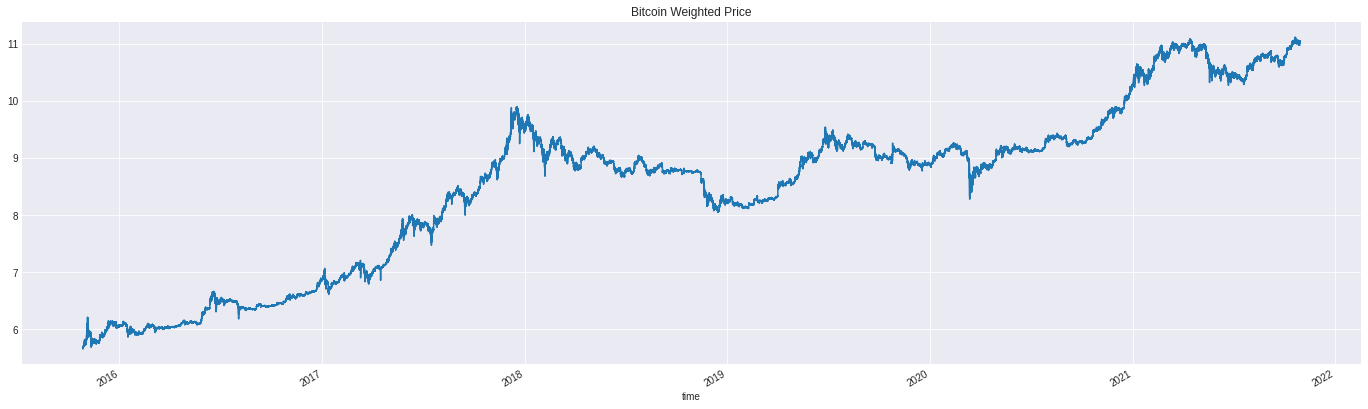

In [9]:
# btc_input_df_datetype.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")
btc_input_df_datetype.set_index("time").close_log.plot(figsize=(24,7), title="Bitcoin Weighted Price")

In [10]:
btc_input_df_datetype['date'] = pd.to_datetime(btc_input_df_datetype['time'],unit='s').dt.date

display(btc_input_df_datetype.head())

group = btc_input_df_datetype.groupby('date')

btc_closing_price_groupby_date = group['close_log'].mean()

display(btc_closing_price_groupby_date.head(10))

,time,low,high,open,close,volume,close_log,date
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079,11.033598,2021-10-30
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357,11.032997,2021-10-30
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848,11.033326,2021-10-30
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070,11.032490,2021-10-30
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128,11.032989,2021-10-30


date
2015-10-27    5.679741
2015-10-28    5.710364
2015-10-29    5.738202
2015-10-30    5.788838
2015-10-31    5.780111
2015-11-01    5.766747
2015-11-02    5.826106
2015-11-03    5.957086
2015-11-04    6.107486
2015-11-05    5.991228
Name: close_log, dtype: float64

In [42]:
btc = pd.DataFrame()
btc['close_log'] =  group['close_log'].mean()
btc['diff1_log'] = btc['close_log'].diff()
btc['diff7_log'] = btc['close_log'].diff(7)
btc['diff30_log'] = btc['close_log'].diff(30)
btc['close'] =  group['close'].mean()
btc['diff1'] = btc['close'].diff()
btc['diff7'] = btc['close'].diff(7)
btc['diff30'] = btc['close'].diff(30)
# btc['reverse_diff'] = btc['close'].shift(1) + btc['diff']
btc['rsi'] = ta.rsi(btc['close'],length=14)
btc['mom'] = ta.mom(btc['close'],length=10)
btc['target_log'] = btc['close_log'].shift(-1)
btc['target'] = btc['close'].shift(-1)
btc = btc.dropna()

In [43]:
btc.tail()

,close_log,diff1_log,diff7_log,diff30_log,close,diff1,diff7,diff30,rsi,mom,target_log,target
date,,,,,,,,,,,,
2021-10-25,11.044651,0.030810,0.013115,0.385202,62611.015403,1901.097458,816.782903,20017.460771,68.402510,2725.561507,11.039727,62304.201403
2021-10-26,11.039727,-0.004924,-0.006909,0.375525,62304.201403,-306.814000,-433.183042,19503.145444,67.047933,1028.473299,10.993767,59508.951285
2021-10-27,10.993767,-0.045959,-0.087671,0.312790,59508.951285,-2795.250118,-5455.561472,15986.450388,56.140175,-1337.288333,11.006138,60252.358194
2021-10-28,11.006138,0.012371,-0.065424,0.362312,60252.358194,743.406910,-4075.249903,18317.494924,58.092845,-1541.874306,11.028101,61584.211944
2021-10-29,11.028101,0.021963,-0.009503,0.386915,61584.211944,1331.853750,-594.829806,19759.308028,61.407790,-1153.172500,11.035381,62030.562210


In [44]:
with open('./drive/MyDrive/btc.moh','wb') as f :
    pickle.dump(btc,f)

# Load data

In [133]:
from google.colab import drive
drive.mount('/content/drive')
with open('./drive/MyDrive/btc.moh','rb') as f :
    btc = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler_t = MinMaxScaler(feature_range=(0, 1))
# scaler_tlog = MinMaxScaler(feature_range=(0, 1))
# StandardScaler
scaler = StandardScaler()
scaler_t = StandardScaler()
scaler_tlog = StandardScaler()


btc.diff1_log = scaler.fit_transform(btc.diff1_log.values.reshape(-1,1))
btc.diff7_log = scaler.fit_transform(btc.diff7_log.values.reshape(-1,1))
btc.diff30_log = scaler.fit_transform(btc.diff30_log.values.reshape(-1,1))
btc.diff1 = scaler.fit_transform(btc.diff1.values.reshape(-1,1))
btc.diff7 = scaler.fit_transform(btc.diff7.values.reshape(-1,1))
btc.diff30 = scaler.fit_transform(btc.diff30.values.reshape(-1,1))
btc.rsi = scaler.fit_transform(btc.rsi.values.reshape(-1,1))
btc.mom = scaler.fit_transform(btc.mom.values.reshape(-1,1))

btc.close = scaler_t.fit_transform(btc.close.values.reshape(-1,1))
btc.target = scaler_t.transform(btc.target.values.reshape(-1,1))

btc.close_log = scaler_tlog.fit_transform(btc.close_log.values.reshape(-1,1))
btc.target_log = scaler_tlog.transform(btc.target_log.values.reshape(-1,1))


In [135]:
prediction_days = 60

df_train_= btc[:][:len(btc)-prediction_days]#values.reshape(-1,1)

df_test_= btc[:][len(btc)-prediction_days:]#.values.reshape(-1,1)

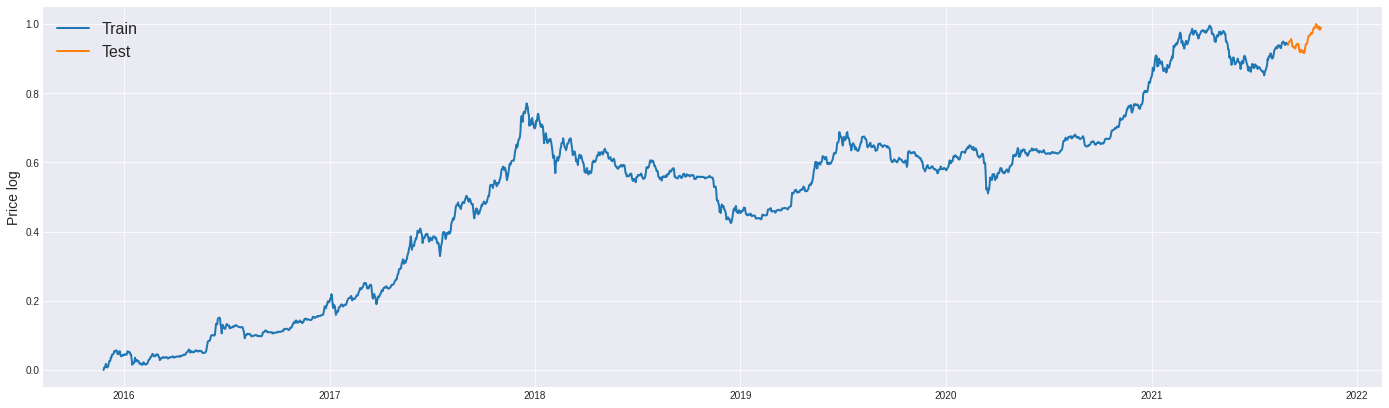

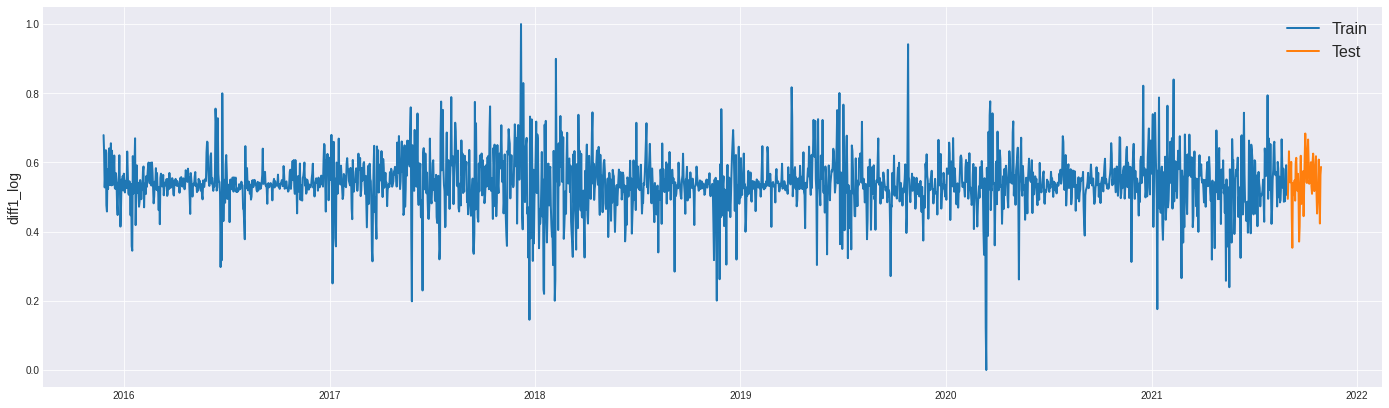

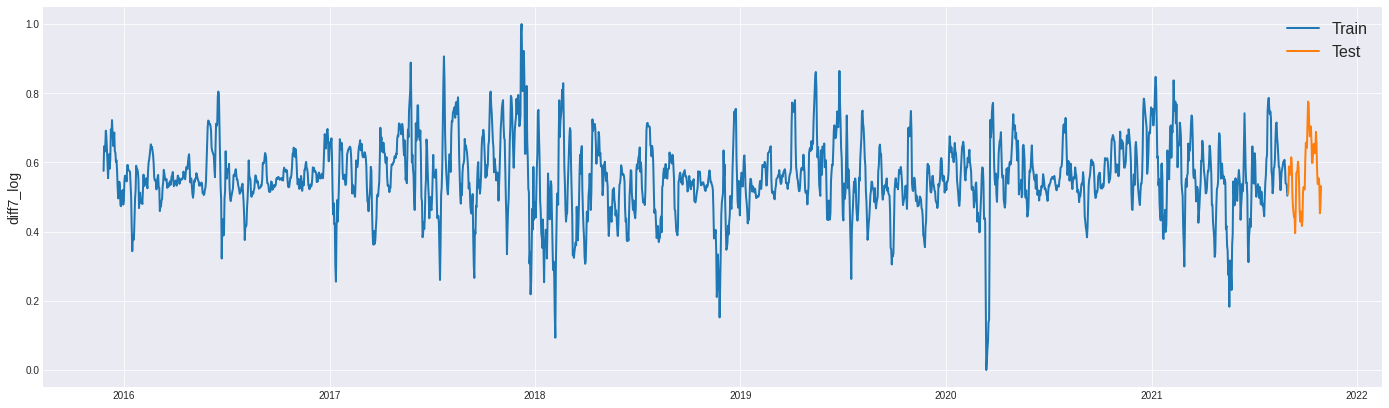

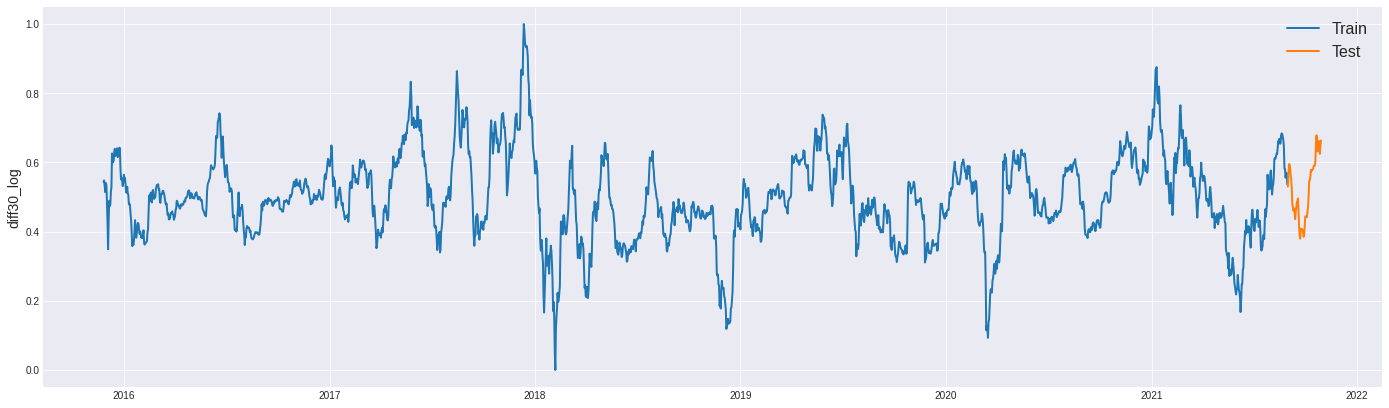

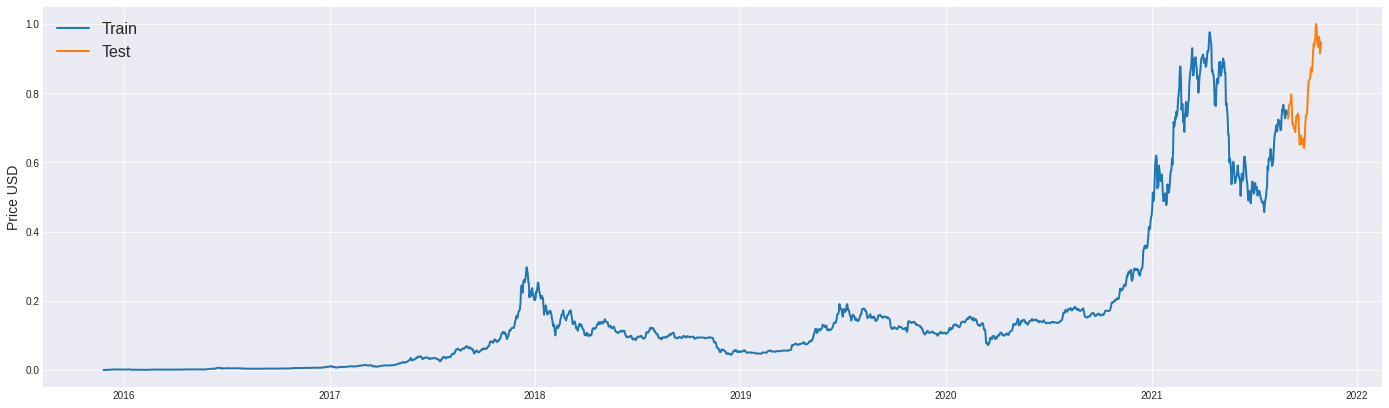

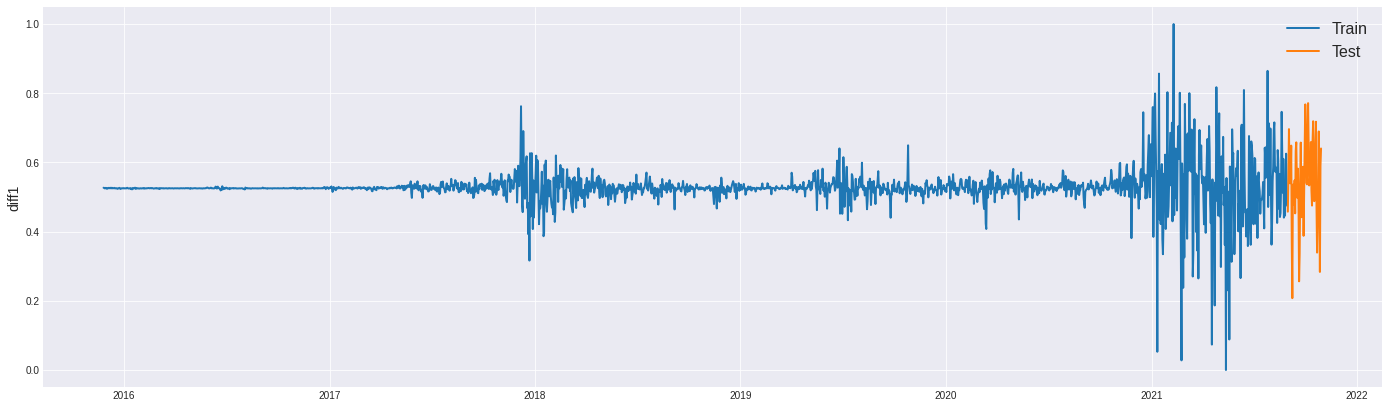

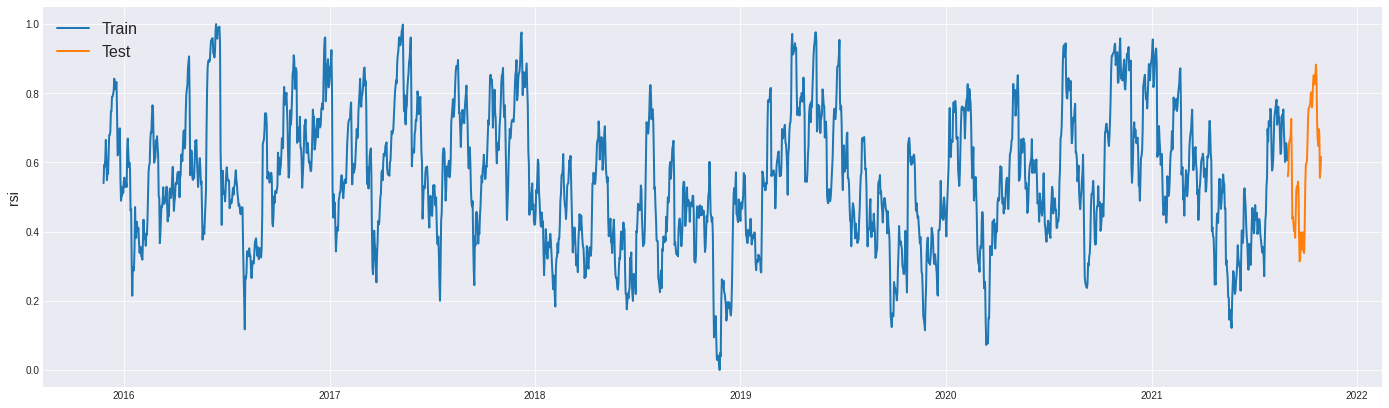

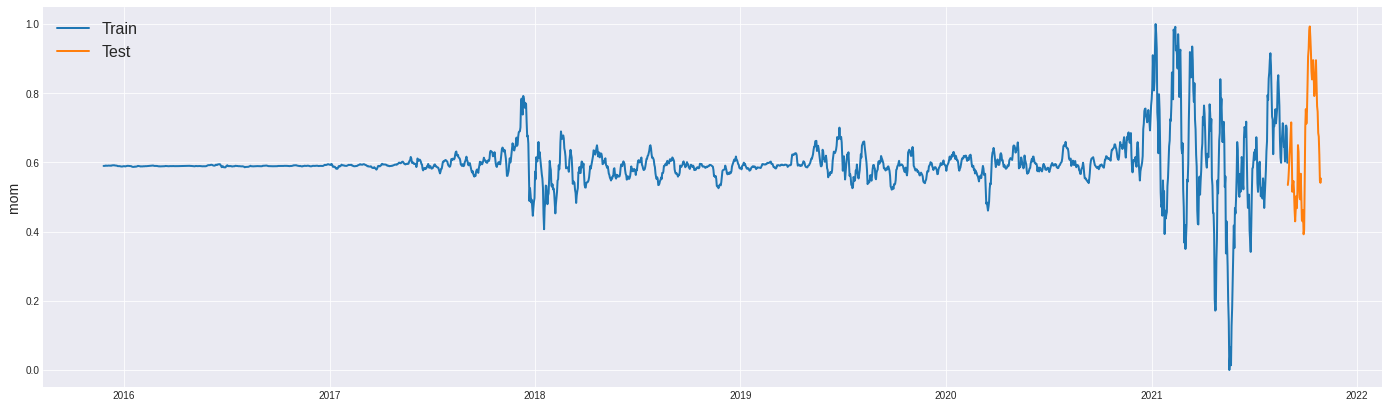

In [95]:
chosen_col = 'Close'

fig, ax = plt.subplots(1, figsize=(24, 7))
ax.plot(df_train_['close_log'], label='Train', linewidth=2)
ax.plot(df_test_['close_log'], label='Test', linewidth=2)
ax.set_ylabel('Price log', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

fig, ax = plt.subplots(1, figsize=(24, 7))
ax.plot(df_train_['diff1_log'], label='Train', linewidth=2)
ax.plot(df_test_['diff1_log'], label='Test', linewidth=2)
ax.set_ylabel('diff1_log', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

fig, ax = plt.subplots(1, figsize=(24, 7))
ax.plot(df_train_['diff7_log'], label='Train', linewidth=2)
ax.plot(df_test_['diff7_log'], label='Test', linewidth=2)
ax.set_ylabel('diff7_log', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

fig, ax = plt.subplots(1, figsize=(24, 7))
ax.plot(df_train_['diff30_log'], label='Train', linewidth=2)
ax.plot(df_test_['diff30_log'], label='Test', linewidth=2)
ax.set_ylabel('diff30_log', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

fig, ax = plt.subplots(1, figsize=(24, 7))
ax.plot(df_train_['close'], label='Train', linewidth=2)
ax.plot(df_test_['close'], label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

fig, ax = plt.subplots(1, figsize=(24, 7))
ax.plot(df_train_['diff1'], label='Train', linewidth=2)
ax.plot(df_test_['diff1'], label='Test', linewidth=2)
ax.set_ylabel('diff1', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

fig, ax = plt.subplots(1, figsize=(24, 7))
ax.plot(df_train_['rsi'], label='Train', linewidth=2)
ax.plot(df_test_['rsi'], label='Test', linewidth=2)
ax.set_ylabel('rsi', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

fig, ax = plt.subplots(1, figsize=(24, 7))
ax.plot(df_train_['mom'], label='Train', linewidth=2)
ax.plot(df_test_['mom'], label='Test', linewidth=2)
ax.set_ylabel('mom', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

# creat data lstm

In [136]:
df_train_.columns

Index(['close_log', 'diff1_log', 'diff7_log', 'diff30_log', 'close', 'diff1',
       'diff7', 'diff30', 'rsi', 'mom', 'target_log', 'target'],
      dtype='object')

In [211]:
df_train = df_train_[:][['close_log', 'target_log']]
df_test = df_test_[:][['close_log', 'target_log']]
df_test.head(2)

,close_log,target_log
date,,
2021-08-31,1.576344,1.581976
2021-09-01,1.581976,1.610896


In [212]:
# many to one

look_back_ = 5

from collections import deque
def dataset_generator_lstm(dataset, look_back=look_back_):
  sequential_data = [] 
  prev_days = deque(maxlen=look_back)
  for i in dataset.values:
    prev_days.append([n for n in i[:-1]])
    if len(prev_days) == look_back:  
      sequential_data.append([np.array(prev_days), i[-1]])
  dataX=[]
  dataY=[]
  for seq, target in sequential_data: 
    dataX.append(seq) 
    dataY.append(target) 
  return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(df_train)

testX, testY = dataset_generator_lstm(df_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testY: ", testX.shape)
print("testY", testY.shape)

trainX:  (2101, 5, 1)
trainY:  (2101,)
testY:  (56, 5, 1)
testY (56,)


# train

In [213]:
regressor = Sequential()

regressor.add(LSTM(units = 256, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
# 

regressor.add(LSTM(units = 128, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))

regressor.add(Dropout(0.2))


regressor.add(Dense(units = 1))

regressor.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 5, 256)            264192    
                                                                 
 dropout_10 (Dropout)        (None, 5, 256)            0         
                                                                 
 lstm_11 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 461,441
Trainable params: 461,441
Non-trainable params: 0
_________________________________________________________________


In [214]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]


# history = regressor.fit(trainX[(len(trainY)-370):], trainY[(len(trainY)-370):], batch_size = 128, epochs = 300, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)
history = regressor.fit(trainX, trainY, batch_size = 128, epochs = 300, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/300
16/17 [===========================>..] - ETA: 0s - loss: 0.8140
Epoch 1: loss improved from inf to 0.83146, saving model to my_best_model.hdf5
17/17 [==============================] - 4s 96ms/step - loss: 0.8315 - val_loss: 1.7180
Epoch 2/300
16/17 [===========================>..] - ETA: 0s - loss: 0.2148
Epoch 2: loss improved from 0.83146 to 0.21015, saving model to my_best_model.hdf5
17/17 [==============================] - 1s 72ms/step - loss: 0.2101 - val_loss: 0.0340
Epoch 3/300
17/17 [==============================] - ETA: 0s - loss: 1.0213
Epoch 3: loss did not improve from 0.21015
17/17 [==============================] - 1s 71ms/step - loss: 1.0213 - val_loss: 0.0232
Epoch 4/300
16/17 [===========================>..] - ETA: 0s - loss: 0.4477
Epoch 4: loss did not improve from 0.21015
17/17 [==============================] - 1s 69ms/step - loss: 0.4370 - val_loss: 0.0436
Epoch 5/300
16/17 [===========================>..] - ETA: 0s - loss: 0.3717
Epoch 5: loss did no

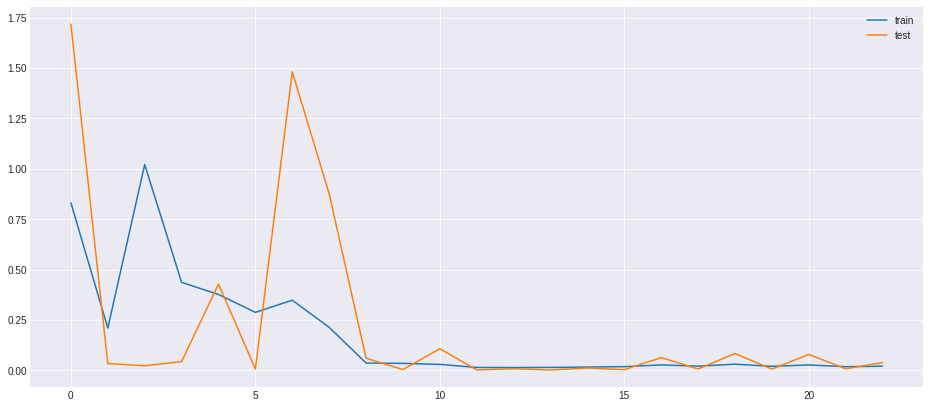

In [215]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [216]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

# test test

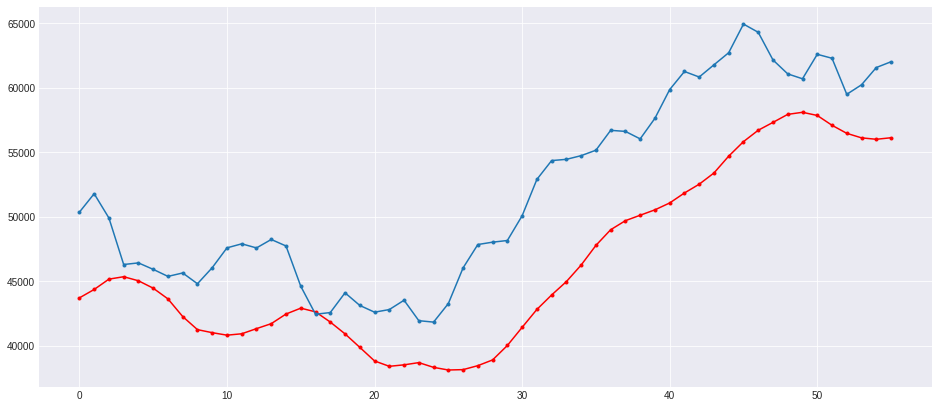

In [218]:
plt.figure(figsize=(16,7))

# log
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
predicted_btc_price_test_data = scaler_tlog.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
test_actual = scaler_tlog.inverse_transform(testY.reshape(-1, 1))

plt.plot(np.exp(predicted_btc_price_test_data), 'r', marker='.', label='Predicted Test')
plt.plot(np.exp(test_actual), marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
# predicted_btc_price_test_data = scaler_t.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
# test_actual = scaler_t.inverse_transform(testY.reshape(-1, 1))

# plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
# plt.plot(test_actual, marker='.', label='Actual Test')
# plt.legend()
# plt.show()

#test train

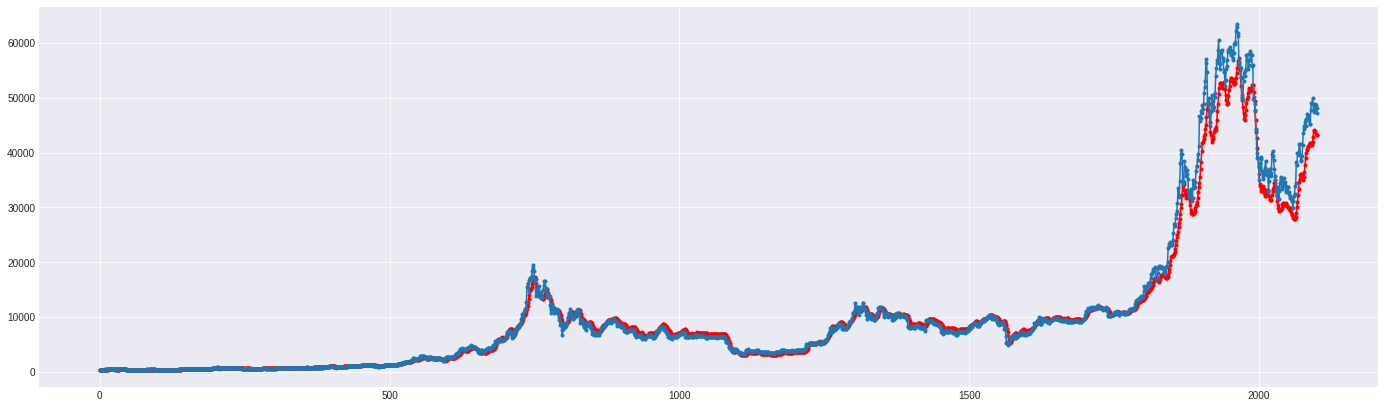

In [222]:
plt.figure(figsize=(24,7))

# log
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
predicted_btc_price_train_data = scaler_tlog.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))
train_actual = scaler_tlog.inverse_transform(trainY.reshape(-1, 1))

plt.plot(np.exp(predicted_btc_price_train_data), 'r', marker='.', label='Predicted Test')
plt.plot(np.exp(train_actual), marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
# predicted_btc_price_train_data = scaler_t.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))
# train_actual = scaler_t.inverse_transform(trainY.reshape(-1, 1))

# plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Test')
# plt.plot(train_actual, marker='.', label='Actual Test')
# plt.legend()
# plt.show()

# score

## log

In [223]:
rmse_lstm_test = math.sqrt(mean_squared_error(np.exp(test_actual), np.exp(predicted_btc_price_test_data)))

print('Test RMSE: %.3f' % rmse_lstm_test)


Test RMSE: 6276.525


In [224]:
rmse_lstm_train = math.sqrt(mean_squared_error(np.exp(train_actual), np.exp(predicted_btc_price_train_data)))

print('Test RMSE: %.3f' % rmse_lstm_train)


Test RMSE: 2010.802


## manoal

In [152]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)


Test RMSE: 2951.213


In [153]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Test RMSE: %.3f' % rmse_lstm_train)


Test RMSE: 1503.741


# future

###### many to one

In [264]:
from collections import deque
SEQ_LEN=len(testX[-1])
prev_days = deque(maxlen=SEQ_LEN)

for i in range(-len(testX[-1]),0,1):
  # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
  prev_days.append(testX[-1][i])

In [265]:
y_p_ = []
future_len = 180
for i in range(future_len):
  x__ = np.array(prev_days).reshape(-1,1).astype(np.float32)

  per = model_from_saved_checkpoint.predict(np.array([x__,x__]))[0].reshape(-1,1)
  prev_days.append(per.reshape(-1,1))
  y_p_.append(per.reshape(-1,1))
  # y_p_.append(scaler.inverse_transform(per.reshape(-1,1)))


In [257]:
# log
y_p_ = scaler_tlog.inverse_transform(np.array(y_p_).reshape(-1, 1))
# manoal
# y_p_ = scaler_t.inverse_transform(np.array(y_p_).reshape(-1, 1))

###### plot future

In [258]:
actual = np.concatenate((train_actual,test_actual))
predicted_btc_price = np.concatenate((predicted_btc_price_train_data, predicted_btc_price_test_data, np.array(y_p_).reshape(-1,1)), axis=0)

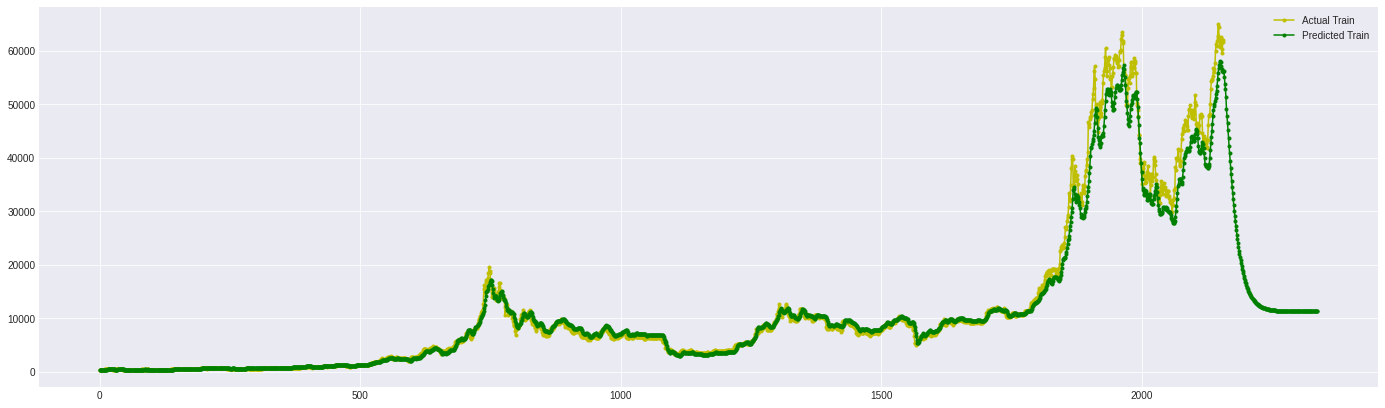

In [268]:
plt.figure(figsize=(24,7))

# log
plt.plot(np.exp(actual),'y', marker='.', label='Actual Train')
plt.plot(np.exp(predicted_btc_price), 'g', marker='.', label='Predicted Train')
# manoal
# plt.plot(actual,'y', marker='.', label='Actual Train')
# plt.plot(predicted_btc_price, 'g', marker='.', label='Predicted Train')


plt.legend()
plt.show()